Contributed by Vahid Monfared, October 2024

# Regression with XGBoost and MLlib pipelines

This notebook utilizes a bike-sharing dataset to demonstrate MLlib pipelines and the XGBoost machine learning algorithm. The goal is to predict the hourly number of bicycle rentals based on various features in the dataset, including the day of the week, weather conditions, season, and more. Predicting demand is a critical task for many businesses, as accurate forecasts enable them to optimize inventory, balance supply with demand, enhance customer satisfaction, and ultimately increase profitability.

The dataset, sourced from the UCI Machine Learning Repository, is available with the Databricks Runtime. It contains data on bicycle rentals from the Capital Bikeshare system during 2011 and 2012. To load the data, use Spark's CSV data source, which generates a Spark DataFrame.

**Data description**

The following columns are included in the dataset:
- Index column:
    - instant: record index
- Feature columns:
    - dteday: date
    - season: season (1:spring, 2:summer, 3:fall, 4:winter)
    - yr: year (0:2011, 1:2012)
    - mnth: month (1 to 12)
    - hr: hour (0 to 23)
    - holiday: 1 if holiday, 0 otherwise
    - weekday: day of the week (0 to 6)
    - workingday: 0 if weekend or holiday, 1 otherwise
    - weathersit: (1:clear, 2:mist or clouds, 3:light rain or snow, 4:heavy rain or snow)
    - temp: normalized temperature in Celsius
    - atemp: normalized feeling temperature in Celsius
    - hum: normalized humidity
    - windspeed: normalized wind speed
- Label columns:
    - casual: count of casual users
    - registered: count of registered users
    - cnt: count of total rental bikes including both casual and registered

This dataset is well-prepared for machine learning algorithms. 

The numerical columns (temp, atemp, hum, and windspeed) are normalized, and categorical values (season, yr, mnth, hr, holiday, weekday, workingday, weathersit) are encoded as indices. Except for the date column (dteday), all columns are numeric.

The objective is to predict the number of bike rentals (cnt column). Upon review, some columns contain redundant information. For example, the cnt column is the sum of the casual and registered columns, so those should be removed. Additionally, the index column instant is not useful as a predictor.
You can also remove the dteday column, as the relevant date information is already captured in the yr, mnth, and weekday columns.

## Install Spark and XGBoost (if necessary)

In [33]:
!pip install xgboost
import xgboost as xgb
import pandas as pd
import numpy as np

In [2]:
!pip install pyspark

In [3]:
!pip install pyspark findspark

## Import libraries

In [4]:
from xgboost.spark import SparkXGBRegressor

In [47]:
!pip install pyspark findspark

import findspark
findspark.init()

from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

df = spark.read.csv("/data/bike-sharing.csv", header="true", inferSchema="true")
# The following command caches the DataFrame in memory. This improves performance since subsequent calls to the DataFrame can read from memory instead of re-reading the data from disk.
df.cache()

DataFrame[instant: int, dteday: date, season: int, yr: int, mnth: int, hr: int, holiday: int, weekday: int, workingday: int, weathersit: int, temp: double, atemp: double, hum: double, windspeed: double, casual: int, registered: int, cnt: int]

In [9]:
display(df)

DataFrame[instant: int, dteday: date, season: int, yr: int, mnth: int, hr: int, holiday: int, weekday: int, workingday: int, weathersit: int, temp: double, atemp: double, hum: double, windspeed: double, casual: int, registered: int, cnt: int]

In [37]:
df.show(5)

+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+---+
|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|cnt|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+---+
|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|      0.0| 16|
|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0| 40|
|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0| 32|
|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0| 13|
|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0|  1|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+---+
only showing top 5 rows



In [10]:
print("The dataset has %d rows." % df.count())

The dataset has 17379 rows.


In [11]:
df = df.drop("instant").drop("dteday").drop("casual").drop("registered")
display(df)

DataFrame[season: int, yr: int, mnth: int, hr: int, holiday: int, weekday: int, workingday: int, weathersit: int, temp: double, atemp: double, hum: double, windspeed: double, cnt: int]

In [38]:
df.show(5)

+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+---+
|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|cnt|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+---+
|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|      0.0| 16|
|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0| 40|
|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0| 32|
|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0| 13|
|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0|  1|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+---+
only showing top 5 rows



In [12]:
df.printSchema()

root
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- cnt: integer (nullable = true)



## Split data into training and test sets
Randomly divide the data into training and test sets. This approach allows you to train and fine-tune the model using the training subset, and then assess its performance on the test set, providing insight into how the model will perform on unseen data.

In [13]:
# Split the dataset randomly into 70% for training and 30% for testing. Passing a seed for deterministic behavior
train, test = df.randomSplit([0.7, 0.3], seed = 0)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 12081 training examples and 5298 test examples.


In [14]:
display(train.select("hr", "cnt"))

DataFrame[hr: int, cnt: int]

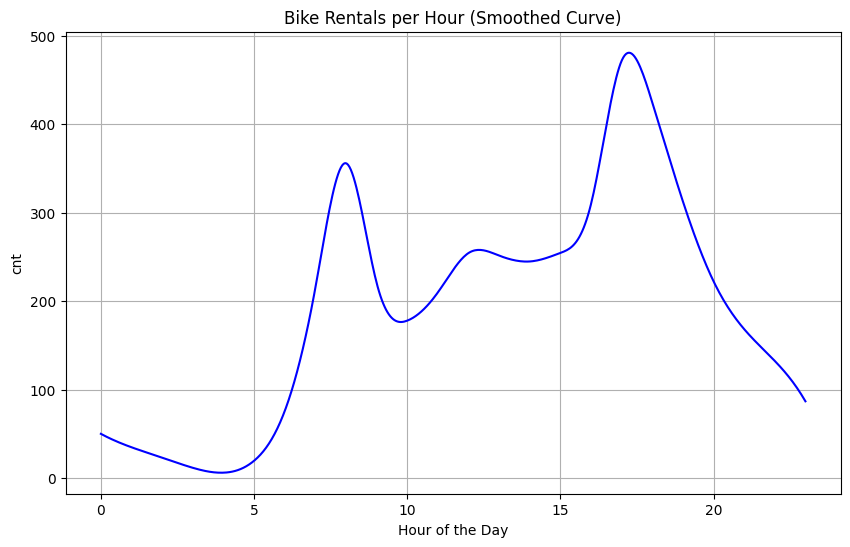

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Select the columns you want to plot (hr and cnt)
train_data = train.select("hr", "cnt").toPandas()  # Convert to Pandas DataFrame

# Sort the data by hour for better plotting
train_data = train_data.sort_values(by="hr")

# Aggregate data for each unique hour, calculating the mean of 'cnt'
# This step ensures we have one 'cnt' value per unique 'hr'
train_data = train_data.groupby('hr')['cnt'].mean().reset_index()


# Prepare data for smoothing
x = train_data['hr'].values
y = train_data['cnt'].values

# Create a smooth curve using make_interp_spline for interpolation
x_smooth = np.linspace(x.min(), x.max(), 500)  # Increase the number of points for a smoother curve
spline = make_interp_spline(x, y)
y_smooth = spline(x_smooth)

# Plot the smooth curve
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, color='b')  # Plotting the smooth curve
plt.title("Bike Rentals per Hour (Smoothed Curve)")
plt.xlabel("Hour of the Day")
plt.ylabel("cnt")
plt.grid(True)
plt.show()

## Visualize the data
You can explore the data visually by plotting it. The following example displays the number of bicycle rentals for each hour of the day. As expected, rentals are low at night and peak during commuting hours.

To create plots in Databricks, use the display() function on a DataFrame and click the plot icon below the table.

To generate the example plot, run the command in the next cell to display a table. From the drop-down menu below the table, select "Line." Then, click "Plot Options." In the dialog box, drag hr to the "Keys" field and cnt to the "Values" field. In the "Keys" field, remove <id> by clicking the "x" next to it. Finally, set the Aggregation drop-down to "AVG."








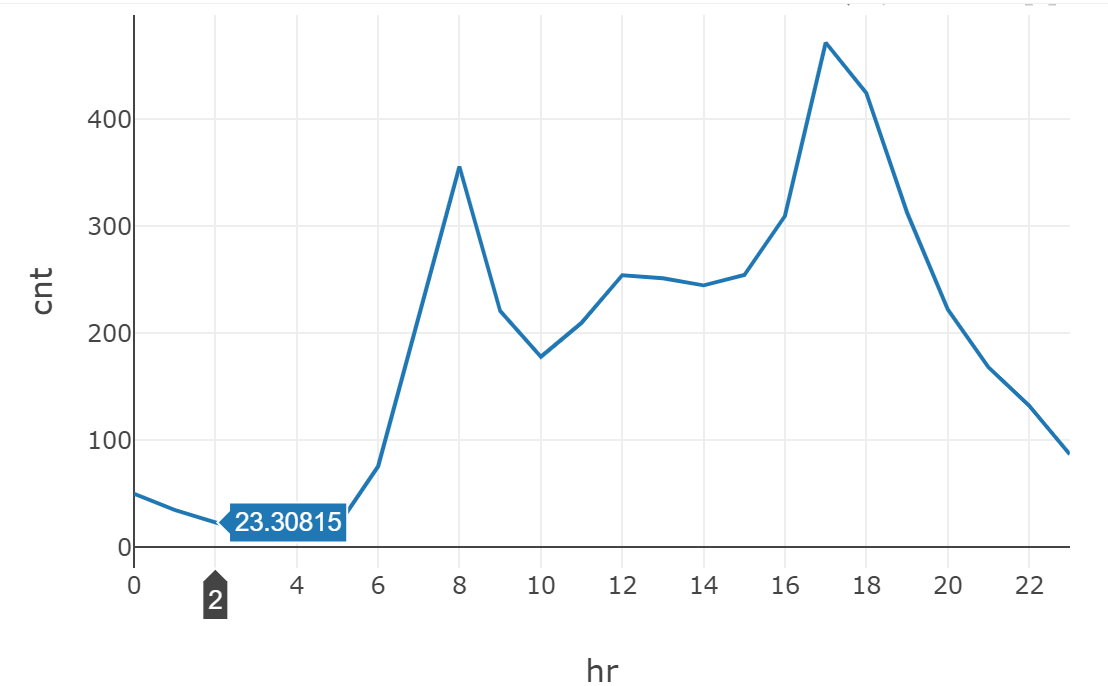

In [15]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer

# Remove the target column from the input feature set.
featuresCols = df.columns
featuresCols.remove('cnt')

# vectorAssembler combines all feature columns into a single feature vector column, "rawFeatures".
vectorAssembler = VectorAssembler(inputCols=featuresCols, outputCol="rawFeatures")

# vectorIndexer identifies categorical features and indexes them, and creates a new column "features".
vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=4)

## Train the machine learning pipeline

After reviewing the data and preparing it as a DataFrame with numeric values, you are ready to train a model to predict future bike-sharing rentals.

Most MLlib algorithms require a single input column containing a vector of features and a single target column. Currently, the DataFrame has separate columns for each feature. MLlib provides functions to help transform the dataset into the required format.

MLlib pipelines combine multiple steps into a single workflow, simplifying the process of iterating and developing the model.

In this example, you will create a pipeline using the following components:

**VectorAssembler**: Combines the feature columns into a single feature vector.
VectorIndexer: Identifies categorical columns by heuristically treating any column with a small number of distinct values as categorical. In this example, yr, season, holiday, workingday, and weathersit are considered categorical.

**SparkXGBRegressor**: Uses the SparkXGBRegressor estimator to learn how to predict bike rental counts based on the feature vectors.

**CrossValidator**: Hyperparameter tuning is demonstrated using cross-validation in Spark. This tool automatically tests a grid of hyperparameters and selects the best-performing model.







In [17]:
from xgboost.spark import SparkXGBRegressor

# The next step is to define the model training stage of the pipeline.
# The following command defines a XgboostRegressor model that takes an input column "features" by default and learns to predict the labels in the "cnt" column.
# Set `num_workers` to the number of Spark tasks you want to concurrently run during training xgboost model.
# Access SparkContext using spark.sparkContext
xgb_regressor = SparkXGBRegressor(num_workers=spark.sparkContext.defaultParallelism, label_col="cnt", missing=0.0)

In [18]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define a grid of hyperparameters to test:
#  - maxDepth: maximum depth of each decision tree
#  - maxIter: iterations, or the total number of trees
paramGrid = ParamGridBuilder()\
  .addGrid(xgb_regressor.max_depth, [2, 5])\
  .addGrid(xgb_regressor.n_estimators, [10, 100])\
  .build()

# Define an evaluation metric.  The CrossValidator compares the true labels with predicted values for each combination of parameters, and calculates this value to determine the best model.
evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol=xgb_regressor.getLabelCol(),
                                predictionCol=xgb_regressor.getPredictionCol())

# Declare the CrossValidator, which performs the model tuning.
cv = CrossValidator(estimator=xgb_regressor, evaluator=evaluator, estimatorParamMaps=paramGrid)

**Train the pipeline**

With the workflow set up, you can now train the pipeline with a single call. When you invoke fit(), the pipeline performs feature processing, hyperparameter tuning, and model training, ultimately returning a fitted pipeline with the best model it identified. This process may take several minutes.

In [19]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, vectorIndexer, cv])

In [20]:
pipelineModel = pipeline.fit(train)

INFO:XGBoost-PySpark:Running xgboost-2.1.1 on 2 workers with
	booster params: {'device': 'cpu', 'max_depth': 2, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.1.1 on 2 workers with
	booster params: {'device': 'cpu', 'max_depth': 2, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.1.1 on 2 workers with
	booster params: {'device': 'cpu', 'max_depth': 5, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-Py

In [21]:
predictions = pipelineModel.transform(test)

## Make predictions and evaluate results

The final step is to use the trained model to make predictions on the test dataset and assess its performance. Evaluating the model's performance on the test set gives an estimate of how well it will perform on unseen data. For instance, if you had weather forecasts for the upcoming week, you could predict the expected bike rentals during that period.

Calculating evaluation metrics is essential for gauging the quality of predictions, comparing different models, and fine-tuning parameters.

In [22]:
display(predictions.select("cnt", "prediction", *featuresCols))

DataFrame[cnt: int, prediction: double, season: int, yr: int, mnth: int, hr: int, holiday: int, weekday: int, workingday: int, weathersit: int, temp: double, atemp: double, hum: double, windspeed: double]

The transform() method of the pipeline model applies the entire pipeline to the input dataset. It executes the feature processing steps on the dataset and then uses the trained XGBoost Regressor model to generate predictions. The result is a DataFrame with an additional column containing the predictions.

In [23]:
rmse = evaluator.evaluate(predictions)
print("RMSE on our test set: %g" % rmse)

RMSE on our test set: 41.5454


In [48]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE calculation
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="cnt", predictionCol="prediction")
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test set: %g" % rmse)

# R² score calculation
evaluator_r2 = RegressionEvaluator(metricName="r2", labelCol="cnt", predictionCol="prediction")
r2 = evaluator_r2.evaluate(predictions)
print("R² score on test set: %g" % r2)

# MAE calculation
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="cnt", predictionCol="prediction")
mae = evaluator_mae.evaluate(predictions)
print("Mean Absolute Error (MAE) on test set: %g" % mae)


Root Mean Squared Error (RMSE) on test set: 41.5454
R² score on test set: 0.946787
Mean Absolute Error (MAE) on test set: 26.3959


A common method for evaluating the performance of a regression model is by calculating the root mean squared error (RMSE). While the RMSE value may not be very meaningful on its own, it is useful for comparing different models. The CrossValidator selects the best model by choosing the one that minimizes the RMSE.

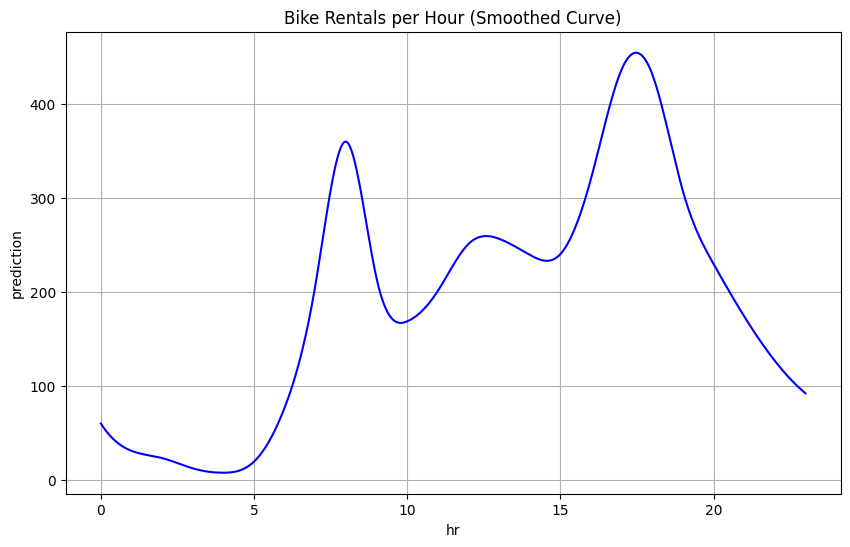

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Select the columns you want to plot (hr and cnt)
# Assuming 'predictions' is the DataFrame containing the 'prediction' column
train_data = predictions.select("hr", "prediction").toPandas()
# Now you should be able to access both 'hr' and 'prediction'
# Sort the data by hour for better plotting
train_data = train_data.sort_values(by="hr")

# Aggregate data for each unique hour, calculating the mean of 'cnt'
# This step ensures we have one 'cnt' value per unique 'hr'
train_data = train_data.groupby('hr')['prediction'].mean().reset_index()


# Prepare data for smoothing
x = train_data['hr'].values
y = train_data['prediction'].values

# Create a smooth curve using make_interp_spline for interpolation
x_smooth = np.linspace(x.min(), x.max(), 500)  # Increase the number of points for a smoother curve
spline = make_interp_spline(x, y)
y_smooth = spline(x_smooth)

# Plot the smooth curve
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, color='b')  # Plotting the smooth curve
plt.title("Bike Rentals per Hour (Smoothed Curve)")
plt.xlabel("hr")
plt.ylabel("prediction")
plt.grid(True)
plt.show()

In [24]:
display(predictions.select("hr", "prediction"))

DataFrame[hr: int, prediction: double]

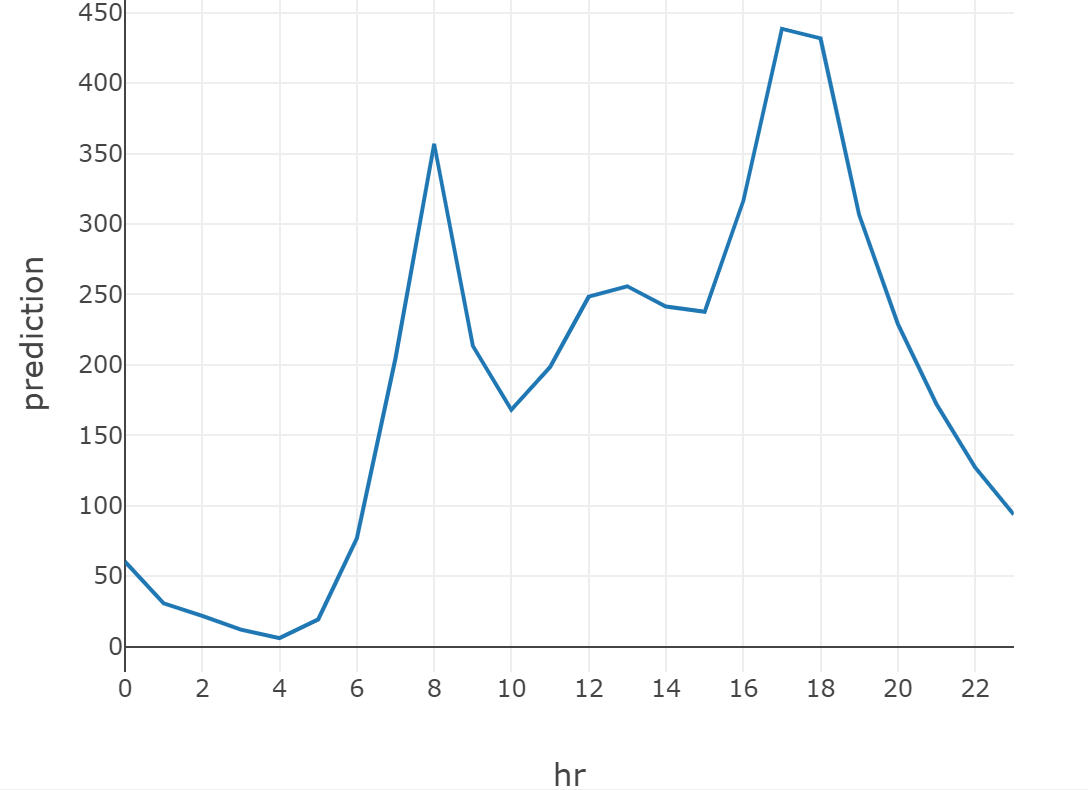

In [42]:
# Assuming 'predictions' is your DataFrame
import pyspark.sql.functions as F

# Group by 'hr' and calculate the average prediction
aggregated_predictions = predictions.groupBy("hr").agg(F.avg("prediction").alias("prediction"))

# Display the aggregated predictions
display(aggregated_predictions.select("hr", "prediction"))

DataFrame[hr: int, prediction: double]

## Save and reload the model

In [29]:
!rm -rf /dbfs/tmp/xgboost/pipeline_001
!rm -rf /dbfs/tmp/xgboost/pipelineModel_001

In [30]:
# Save the pipeline that created the model
pipeline.save('/tmp/xgboost/pipeline_001')

# Save the model itself
pipelineModel.save('/tmp/xgboost/pipelineModel_001')

In [31]:
# Load the pipeline
loaded_pipeline = Pipeline.load('/tmp/xgboost/pipeline_001')

In [32]:
# Load and use the model
from pyspark.ml import PipelineModel

loaded_pipelineModel = PipelineModel.load('/tmp/xgboost/pipelineModel_001')

# To represent new data, use the first 3 rows of the test dataset
new_data = test.limit(3)

# Make predictions with the loaded model
new_preds = loaded_pipelineModel.transform(new_data)
display(new_preds.select("cnt", "prediction", *featuresCols))

DataFrame[cnt: int, prediction: double, season: int, yr: int, mnth: int, hr: int, holiday: int, weekday: int, workingday: int, weathersit: int, temp: double, atemp: double, hum: double, windspeed: double]